# SST (Spatial Stress Test) Analysis

Data Collected June 2015

In [2]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

### Set up directories & exp-specific information

In [3]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')
dirs['shortcut_file'] = op.join(dirs['datadir'], 'shortcut_coords.csv')

In [4]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

### Read in subject information

In [5]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info

,subid,group,voltage,remove
0,1,pilot,0,NaN
1,2,pilot,0,NaN
2,3,pilot,0,NaN
3,4,pilot,0,NaN
4,5,pilot,0,NaN
5,6,pilot,0,NaN
6,7,pilot,0,NaN
7,8,pilot,0,NaN


In [6]:
shortcut_coords = pd.read_csv(dirs['shortcut_file'])
shortcut_coords

,env,x_lo,x_hi,y_lo,y_hi
0,env1,16,32,0,24
1,env2,8,28,28,48
2,env3,24,40,16,24
3,env4,16,32,16,24
4,env5,8,36,24,40
5,env6,24,40,24,40
6,env7,8,48,32,40
7,env8,16,32,0,16
8,env9,24,35,0,12
9,env10,48,56,24,40


## Read in data files

In [7]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = True

test_types = ['day2_noarrows_round2', 'day3_test1', 'day3_test2']
test_trials = ['training', 'test1', 'test2']

# iterate through subjects
for subid in subj_info.subid:
    print subid
    
    if test:
        # iterate through environments
        for env in proj['envs']:
            for test_type, test_trial in zip(test_types, test_trials):
    #             print env
                # add test file
                test_file = glob.glob(op.join(dirs['datadir'], 'nav', test_type, env, 
                                    subid,'session_*', 'log.txt'))[0]
                output = []
                with open(test_file) as f:
                    data = f.readlines()

                    for line in data:
                        columns = re.split('\t|\r|\n', line)
                        output.append(columns)
                d2 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                     'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

                # include subid and env
                d2['subid'] = subid
                d2['env'] = env
                d2['test_trial'] = test_trial

                # force time to be integer, diff from end to beginning
                d2.time = d2.time.astype(int)
                d2.time = d2.time - d2.time.min()

                df = df.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

1
2
3
4
5
6
7
8


## Look at data

In [8]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,env,test_trial
0,0,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,1,env1,training
1,140,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,1,env1,training
2,140,0,VR_INIT,,,None,None,None,None,1,env1,training
3,140,0,VR_CREATED,,,None,None,None,None,1,env1,training
4,1946,0,CONF_LOAD,./config.py,None,,,None,None,1,env1,training


### Look at 2D position in space

In [9]:
dp = df[df.command == 'VROBJECT_POS'].reset_index()
dp = dp.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dp.head()

,time,c2,c3,c4,subid,env,test_trial
0,6656,1,terrain,"LPoint3f(0, 0, 0)",1,env1,training
1,6656,1,zebra,"LPoint3f(4, 34, 0.5)",1,env1,training
2,6656,1,lettuce,"LPoint3f(26, 52, 0.5)",1,env1,training
3,6656,1,George_Clooney,"LPoint3f(20, 22, 0.5)",1,env1,training
4,6656,1,zzz,"LPoint3f(12, 52, 0.2)",1,env1,training


In [10]:
dp = dp.join(pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist()).reindex(columns=[2, 3, 4]))
dp.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)
dp = dp.drop(['c4', 'c2'], 1)
dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
dp.head()

,time,c3,subid,env,test_trial,x,y,z
0,6656,terrain,1,env1,training,0,0,0.0
1,6656,zebra,1,env1,training,4,34,0.5
2,6656,lettuce,1,env1,training,26,52,0.5
3,6656,George_Clooney,1,env1,training,20,22,0.5
4,6656,zzz,1,env1,training,12,52,0.2


## Plot environment

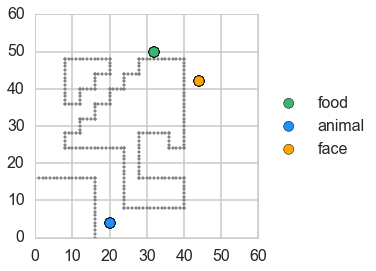

In [11]:
def plot_env(env):
    plot_environment(env, dp, proj)
    
env_opts = widgets.Dropdown(options=list(dp.env.unique()))

w = widgets.interact(plot_env, 
                     env=env_opts)

## Visualize paths 

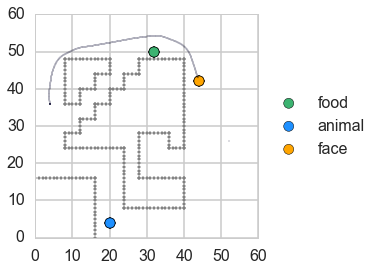

In [12]:
def plot_sub(subj, env, test_trial):
    plot_paths(env=env, subj=subj, 
           dp=dp[dp.test_trial == test_trial], 
           proj=proj)
    
subj_opts = widgets.Dropdown(options=list(dp.subid.unique()))
env_opts = widgets.Dropdown(options=list(dp.env.unique()))
test_opts = widgets.Dropdown(options=list(['test1', 'test2']))

w = widgets.interact(plot_sub, 
                     subj=subj_opts, 
                     env=env_opts, 
                     test_trial=test_opts)